In [342]:
from astropy.io import fits
from astropy.wcs import WCS
import png
import numpy as np
from utils import zscale
import matplotlib.pyplot as plt
import math
import scipy

TOTAL_VELOCITY_VECTORS = 500
IMAGES_TO_STACK = ['Rate_Track_Test/frame1.png', 'Rate_Track_Test/frame2.png', 'Rate_Track_Test/frame3.png', 'Rate_Track_Test/frame4.png', 
                   'Rate_Track_Test/frame5.png', 'Rate_Track_Test/frame6.png', 'Rate_Track_Test/frame7.png', 'Rate_Track_Test/frame8.png']
NUM_FRAMES = len(IMAGES_TO_STACK)
DIMENSIONS = (512, 512)

In [288]:
#Convert all images to greyscale
from PIL import Image

for path in IMAGES_TO_STACK:
    img = Image.open(path).convert('L')
    img.save(path)

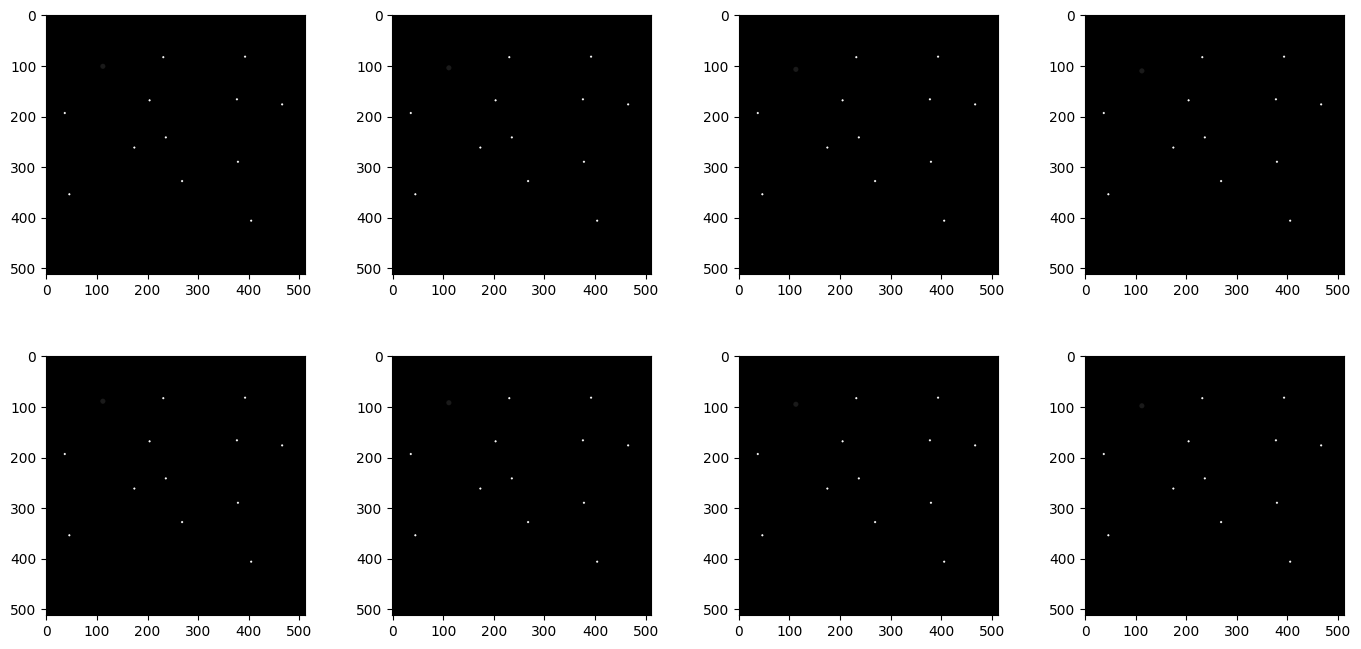

In [289]:
plt.rcParams["figure.figsize"] = [14.00, 15.00]
plt.rcParams["figure.autolayout"] = True
plt.subplot(1, 4, 1)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame1.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(1, 4, 2)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame2.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(1, 4, 3)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame3.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(1, 4, 4)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame4.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(2, 4, 1)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame5.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(2, 4, 2)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame6.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(2, 4, 3)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame7.png').asDirect()[2]))), cmap="Greys_r")
plt.subplot(2, 4, 4)
plt.imshow(np.vstack(list(map(np.uint16, png.Reader('Rate_Track_Test/frame8.png').asDirect()[2]))), cmap="Greys_r")
plt.show()

Creates the predictive velocity vectors in which shifts will be applied

In [343]:
#For rounding
a = int(math.sqrt(TOTAL_VELOCITY_VECTORS)) 
b = math.floor(a/2)
if a % 2 == 0:
    a += 1

velocities = np.zeros(shape = (a * a, 2))

idx = 0
for i in range(-b, b+1):
    for j in range(-b, b+1):
        velocities[idx] = np.asarray([i,j])
        idx += 1

In [344]:
def stack(file_paths: list, velocity_vector):
    '''
    Inputs:
        file_path is a list of strings refering to the images that are to be stacked
        
        velocity_vector is a 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.

    Output:
        a stacked image of all frames.
    '''
    final_dimensions = DIMENSIONS
    stacked_image = np.zeros(shape=final_dimensions)
    iter = 0
    init_x_vel = velocity_vector[0]
    init_y_vel = velocity_vector[1]

    for img in file_paths:
        image_data = png.Reader(img).asDirect()
        image = np.vstack(list(map(np.uint16, image_data[2])))
        img_shifted = scipy.ndimage.shift(image, velocity_vector, mode='constant')
        if iter != 0:
            stacked_image += img_shifted
        iter += 1
        velocity_vector = [init_y_vel * iter, init_x_vel * iter]
    return stacked_image

Example usage of the stack function with velocity vector [0, -3]

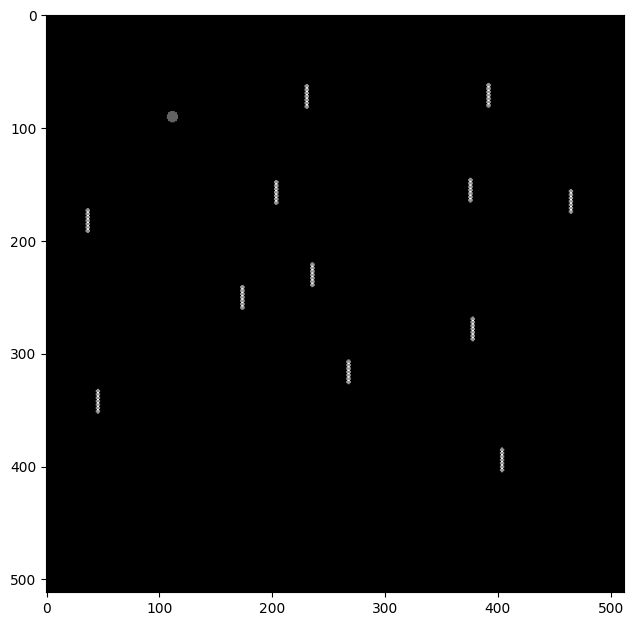

In [320]:
plt.rcParams["figure.figsize"] = [7.5, 7.5]
plt.rcParams["figure.autolayout"] = False
final = stack(IMAGES_TO_STACK, [0, -3])
plt.imshow((final), cmap="Greys_r")

In [346]:
def build_data_cube(file_paths, all_vectors):
    '''
    Creates a dictionary of stacked frames for each velocity vector

    Inputs: file_path is a list of strings refering to the images that are to be stacked

    all_vectors is a list of 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.
    
    Output: a dictionary of the final stacked frames where the velocity vector in tuple 
        form is the key for retreiving a stacked image.
    '''
    data_cube = {}
    for velocity in all_vectors:
        stacked_image = stack(file_paths=file_paths, velocity_vector=velocity)
        data_cube[tuple(velocity)] = stacked_image
    return data_cube

data_cube = build_data_cube(IMAGES_TO_STACK, velocities)

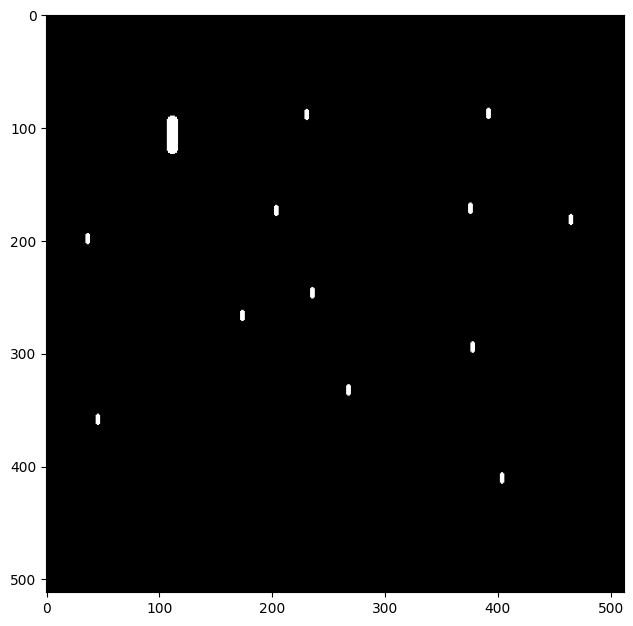

In [337]:
stacked_image = data_cube[(0,1)]
plt.imshow(zscale(stacked_image), cmap="Greys_r")